# Neural Symbolic Learner# NeuralSymbolic - Demo

## Dependencies

In [6]:
!pip install keras-rectified-adam keras.utils tqdm numpy pandas scikit-learn tensorflow matplotlib

In [7]:
pip install --upgrade tensorflow

In [8]:
import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut
import keras
from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate
from keras.losses import binary_crossentropy
from keras.utils import plot_model
from keras_radam import RAdam
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [9]:
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import random
import os

seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ["PYTHONHASHSEED"] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)


## Import Data from CSV

In [10]:
# path to the data
path = "trains-uptated.csv"
str_att = {
    "length": ["short", "long"],
    "shape": [
        "closedblopnrect",
        "closedtrap",
        "closedrect",
        "closedushaped",
        "dblopnrect",
        "ellipse",
        "hexagon",
        "jaggedrect",
        "openrect",
        "opentrap",
        "slopetopdblopnrect",
        "slopetoprect",
        "slopetoptrap",
        "slopetopushaped",
        "ushaped",
    ],
    "load_shape": ["circlelod", "hexagonlod", "rectanglod", "trianglod"],
    "Class_attribute": ["west", "east"],
}


def read_data(path=path):
    df = pd.read_csv(path, sep=",")

    # Mapeia os atributos categóricos para valores numéricos
    for k in df.columns:
        for att in str_att:
            if k.startswith(att):
                df[k] = df[k].apply(lambda x: str_att[att].index(x) if x in str_att[att] else x)

    # Substitui valores especiais por números
    df.replace({"\\0": 0, "None": -1}, inplace=True)

    # Converte todas as colunas para numéricas, forçando erros para NaN e então preenchendo
    df = df.apply(pd.to_numeric, errors='coerce').fillna(-1)

    return df



df = read_data()
df


,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,4,2.0,2,1,8,1.0,2.0,2,0,8,...,1,0,0,0,0,0,0,0,0,1
1,4,2.0,2,0,8,2.0,0.0,2,0,1,...,0,0,1,0,0,0,0,0,0,1
2,4,3.0,2,0,14,1.0,3.0,2,0,8,...,1,0,1,0,0,0,0,0,0,1
3,5,3.0,2,0,9,1.0,0.0,2,0,14,...,1,0,0,0,0,1,0,0,0,1
4,4,3.0,2,0,2,1.0,3.0,2,0,1,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5,3.0,2,0,8,3.0,2.0,2,0,6,...,0,0,1,1,0,1,0,0,0,0
96,3,2.0,2,0,6,2.0,0.0,2,1,2,...,0,0,1,0,0,0,0,0,0,0
97,3,2.0,2,0,11,1.0,0.0,3,1,2,...,0,0,0,1,0,0,0,0,0,0
98,3,1.0,2,0,11,1.0,3.0,2,0,8,...,0,0,0,1,0,0,0,0,0,0


## Question 1.


In [11]:
df = read_data()
Y = np.array(df.pop('Class_attribute'))
X = np.array(df)

### Akin Propositionalization Model

In [12]:
# define model
def model_1():
    model = Sequential(
        [
            Dense(32, activation=tf.nn.relu, input_shape=(len(df.keys()),)),
            Dense(1, activation=tf.nn.sigmoid),
        ]
    )
    model.compile(
        loss='binary_crossentropy', optimizer='adam', metrics=["mse", "binary_accuracy"]
    )
    return model


es = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=1000, verbose=0
)

model = model_1()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,089 (4.25 KB)

 Trainable params: 1,089 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

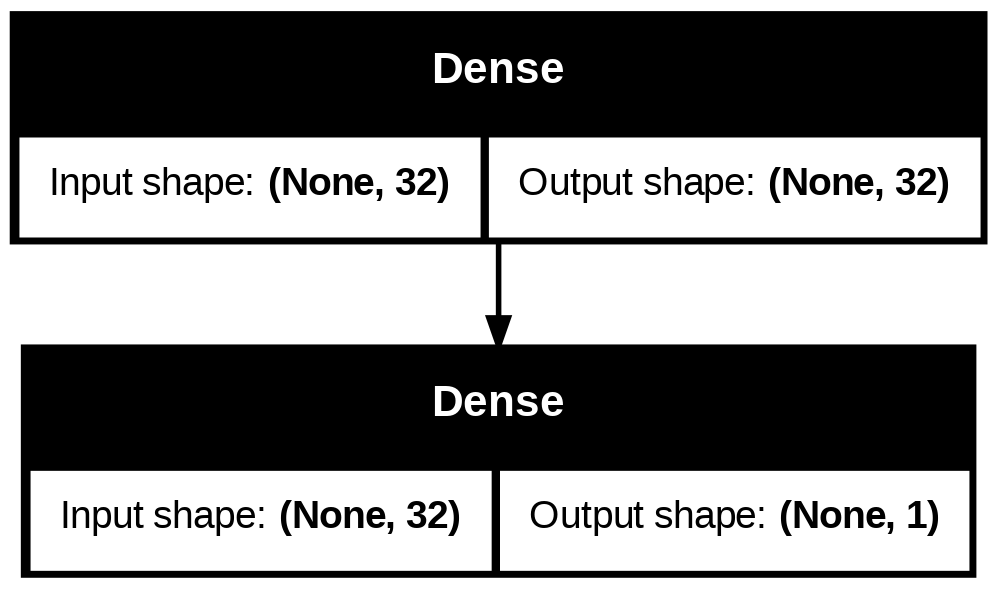

In [13]:
plot_model(model, show_shapes=True, show_layer_names=False)

### Train

Questão 1. a)

In [14]:
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import tqdm


# Inicializando dicionários e listas
hists = dict()
question_1_names = ["Fold", "Output of flat network", "Desired output", "Class"]
question_1 = {name: [] for name in question_1_names}
# Separar os dados em treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

# Inicializar o modelo e treinar
model = model_1()
hist = model.fit(
    np.array(X_train, dtype=float),
    np.array(Y_train, dtype=float),
    validation_data=(np.array(X_test, dtype=float), np.array(Y_test, dtype=float)),
    epochs=1000,
    verbose=0,
)

# Armazenar os resultados
hists = hist
question_1 = {
    "Train": [0],  # Como agora você tem apenas um conjunto de treino, adicionamos 0
    "Output of flat network": model.predict(np.array(X_test, dtype=float)).tolist(),
    "Desired output": np.array(Y_test, dtype=float).tolist(),
    "Class": [str_att["Class_attribute"][int(y)] for y in Y_test]
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [15]:
def check_rules(df, model_predictions, y_true, str_att):
    # Recupera os rótulos das classes
    class_labels = str_att["Class_attribute"]

    # Certifica-se de que as previsões são um array unidimensional
    model_predictions = np.array(model_predictions).flatten()

    # 1. Regra A: Vagão curto e fechado
    rule_a_indices = (
        (df['length1'] == str_att['length'].index('short')) &
        (df['shape1'] == str_att['shape'].index('closedrect'))
    )
    rule_a_predictions = [class_labels[int(round(pred))] for pred, cond in zip(model_predictions, rule_a_indices) if cond]
    rule_a_actuals = [class_labels[int(y)] for y, cond in zip(y_true, rule_a_indices) if cond]

    rule_a_correct = [a == 'east' for a in rule_a_actuals]

    # 2. Regra B: Dois vagões ou teto irregular
    irregular_roof_shapes = [str_att['shape'].index(s) for s in ['slopetopushaped']]
    rule_b_indices = (
        (df['Number_of_cars'] == 2) |
        (df[['shape1', 'shape2', 'shape3', 'shape4']].isin(irregular_roof_shapes).any(axis=1))
    )
    rule_b_predictions = [class_labels[int(round(pred))] for pred, cond in zip(model_predictions, rule_b_indices) if cond]
    rule_b_actuals = [class_labels[int(y)] for y, cond in zip(y_true, rule_b_indices) if cond]

    rule_b_correct = [a == 'west' for a in rule_b_actuals]

    # 3. Regra C: Mais de dois tipos diferentes de carga
    num_loads_cols = ['num_loads1', 'num_loads2', 'num_loads3', 'num_loads4']
    rule_c_indices = df[num_loads_cols].apply(lambda row: len(set(row)) > 2, axis=1)
    rule_c_predictions = [class_labels[int(round(pred))] for pred, cond in zip(model_predictions, rule_c_indices) if cond]
    rule_c_actuals = [class_labels[int(y)] for y, cond in zip(y_true, rule_c_indices) if cond]

    rule_c_correct = [a == 'east' for a in rule_c_actuals]

    return {
        'Rule A': rule_a_correct,
        'Rule B': rule_b_correct,
        'Rule C': rule_c_correct
    }

# Aplicar a função
results = check_rules(df, question_1['Output of flat network'], question_1['Desired output'], str_att)

# Imprimir os resultados
print("Results for each rule:")
for rule, correctness in results.items():
    print(f"{rule}: {correctness}")


Results for each rule:
Rule A: [False, True, True]
Rule B: []
Rule C: [False, True, False, True, False]


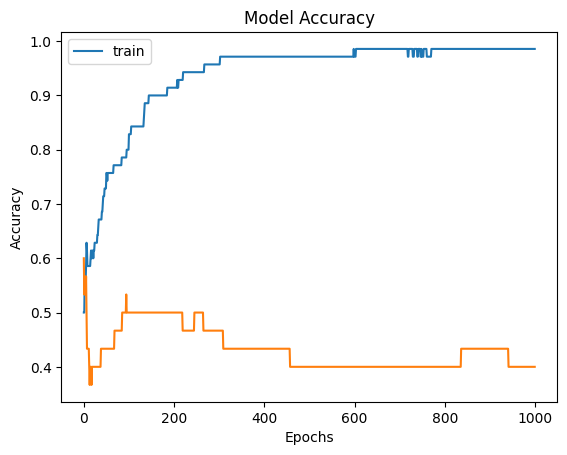

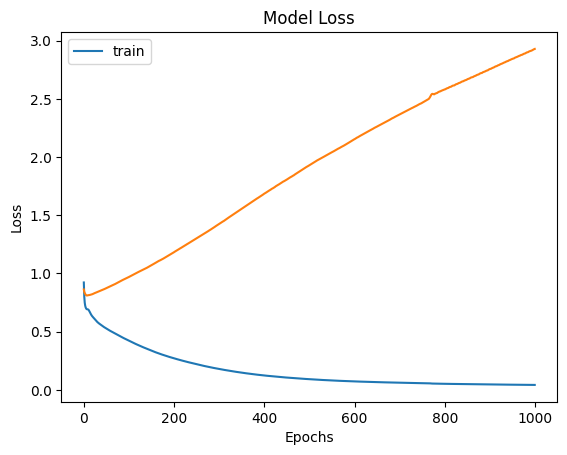

In [16]:
plt.plot(hist.history['binary_accuracy'], c='tab:blue')
plt.plot(hist.history['val_binary_accuracy'], c='tab:orange')
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'], c='tab:orange')
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train'], loc='upper left')
plt.show()

Results

Questão 1. b)

In [17]:
from sklearn.model_selection import KFold
import numpy as np
import tqdm
import pandas as pd

# Definindo o número de folds
n_splits = 5  # ou outro número que você desejar

# Inicializando o KFold com random_state
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Inicializando dicionários e listas
hists = dict()
question_1_names = ["Fold", "Output of flat network", "Desired output", "Class"]
question_1 = {name: [] for name in question_1_names}

# Loop sobre os folds
all_predictions = []
all_true_labels = []
for i, (train_index, test_index) in tqdm.tqdm(enumerate(kf.split(X)), total=n_splits):
    x_train, x_test = np.array(X[train_index], dtype=float), np.array(X[test_index], dtype=float)
    y_train, y_test = np.array(Y[train_index], dtype=float), np.array(Y[test_index], dtype=float)

    # Criação e treinamento do modelo
    model = model_1()
    hist = model.fit(
        x_train,
        y_train,
        validation_data=[x_test, y_test],
        epochs=1000,
        verbose=0,
    )
    hists[i] = hist

    # Armazenamento dos resultados
    question_1["Fold"].append(i)
    predictions = model.predict(x_test).flatten()
    question_1["Output of flat network"].extend(predictions)
    question_1["Desired output"].extend(y_test)
    question_1["Class"].extend([str_att["Class_attribute"][int(y)] for y in y_test])
    all_predictions.extend(predictions)
    all_true_labels.extend(y_test)

# Concatenação dos resultados para todos os folds
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|██        | 1/5 [01:07<04:30, 67.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 40%|████      | 2/5 [02:13<03:19, 66.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|██████    | 3/5 [03:19<02:12, 66.36s/it]WARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7dfdb31f5900> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 80%|████████  | 4/5 [04:24<01:05, 65.85s/it]WARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7dfdb2e5a170> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|██████████| 5/5 [05:29<00:00, 65.88s/it]


In [18]:
# Converter as colunas relevantes para inteiros
for col in ['length1', 'shape1', 'Number_of_cars', 'shape2', 'shape3', 'shape4', 'num_loads1', 'num_loads2', 'num_loads3', 'num_loads4']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(-1).astype(int)

# Função de verificação das regras
def check_rules(df, model_predictions, y_true, str_att):
    # Recupera os rótulos das classes
    class_labels = str_att["Class_attribute"]

    # Certifica-se de que as previsões são um array unidimensional
    model_predictions = np.array(model_predictions).flatten()

    # 1. Regra A: Vagão curto e fechado
    rule_a_indices = (
        (df['length1'] == str_att['length'].index('short')) &
        (df['shape1'] == str_att['shape'].index('closedrect'))
    )
    rule_a_predictions = [class_labels[int(round(pred))] for pred, cond in zip(model_predictions, rule_a_indices) if cond]
    rule_a_actuals = [class_labels[int(y)] for y, cond in zip(y_true, rule_a_indices) if cond]

    rule_a_correct = [a == 'east' for a in rule_a_actuals]

    # 2. Regra B: Dois vagões ou teto irregular
    irregular_roof_shapes = [str_att['shape'].index(s) for s in ['slopetopushaped']]
    rule_b_indices = (
        (df['Number_of_cars'] == 2) |
        (df[['shape1', 'shape2', 'shape3', 'shape4']].isin(irregular_roof_shapes).any(axis=1))
    )
    rule_b_predictions = [class_labels[int(round(pred))] for pred, cond in zip(model_predictions, rule_b_indices) if cond]
    rule_b_actuals = [class_labels[int(y)] for y, cond in zip(y_true, rule_b_indices) if cond]

    rule_b_correct = [a == 'west' for a in rule_b_actuals]

    # 3. Regra C: Mais de dois tipos diferentes de carga
    num_loads_cols = ['num_loads1', 'num_loads2', 'num_loads3', 'num_loads4']
    rule_c_indices = df[num_loads_cols].apply(lambda row: len(set(row)) > 2, axis=1)
    rule_c_predictions = [class_labels[int(round(pred))] for pred, cond in zip(model_predictions, rule_c_indices) if cond]
    rule_c_actuals = [class_labels[int(y)] for y, cond in zip(y_true, rule_c_indices) if cond]

    rule_c_correct = [a == 'east' for a in rule_c_actuals]

    return {
        'Rule A': rule_a_correct,
        'Rule B': rule_b_correct,
        'Rule C': rule_c_correct
    }

# Criar um DataFrame do df original com apenas as colunas necessárias
df_test = df.loc[:, ['length1', 'shape1', 'Number_of_cars', 'shape2', 'shape3', 'shape4', 'num_loads1', 'num_loads2', 'num_loads3', 'num_loads4']]

# Aplicar a função de verificação das regras
results = check_rules(df_test, all_predictions, all_true_labels, str_att)

# Imprimir os resultados
print("Results for each rule:")
for rule, correctness in results.items():
    print(f"{rule}: {correctness}")

Results for each rule:
Rule A: [True, False, False, False, True, True, False, True]
Rule B: [False]
Rule C: [True, True, True, False, False, False, True, True, False, False, False, False, True, True, True, True, True, False, False, True, False]


In [19]:
# Verificar alguns exemplos de históricos de treinamento
for key in list(hists.keys())[:3]:  # Mostrar os três primeiros
    print(f"Histórico para teste {key}: {hists[key].history}")

Histórico para teste 0: {'binary_accuracy': [0.512499988079071, 0.512499988079071, 0.5375000238418579, 0.5874999761581421, 0.5625, 0.574999988079071, 0.5375000238418579, 0.574999988079071, 0.574999988079071, 0.6000000238418579, 0.6000000238418579, 0.612500011920929, 0.612500011920929, 0.574999988079071, 0.574999988079071, 0.6000000238418579, 0.6000000238418579, 0.5874999761581421, 0.6000000238418579, 0.612500011920929, 0.6000000238418579, 0.612500011920929, 0.625, 0.6499999761581421, 0.6499999761581421, 0.6625000238418579, 0.699999988079071, 0.7124999761581421, 0.7124999761581421, 0.7250000238418579, 0.699999988079071, 0.7124999761581421, 0.7250000238418579, 0.7250000238418579, 0.737500011920929, 0.737500011920929, 0.737500011920929, 0.737500011920929, 0.737500011920929, 0.75, 0.75, 0.762499988079071, 0.762499988079071, 0.762499988079071, 0.7749999761581421, 0.7749999761581421, 0.7749999761581421, 0.762499988079071, 0.762499988079071, 0.762499988079071, 0.762499988079071, 0.77499997615

### Results

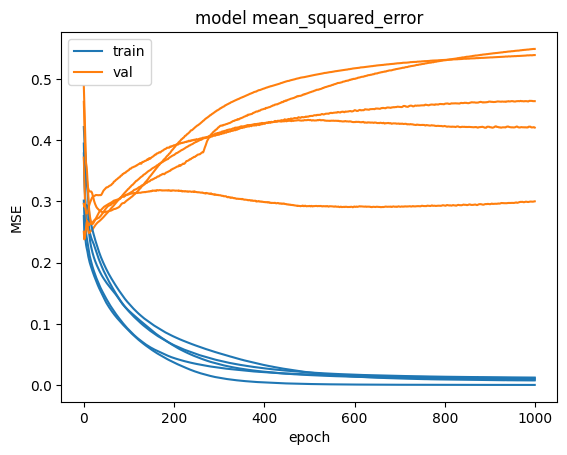

In [20]:
for i, history in enumerate(hists.values()):
    plt.plot(history.history['mse'], c='tab:blue')
    plt.plot(history.history['val_mse'], c='tab:orange')

plt.title('model mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


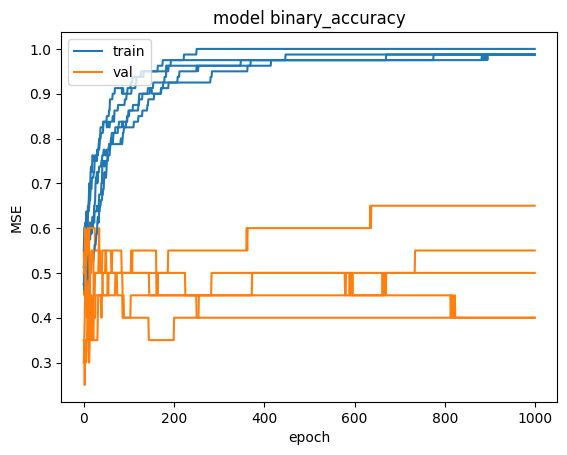

In [21]:
for i, history in enumerate(hists.values()):
    plt.plot(history.history['binary_accuracy'], c='tab:blue')
    plt.plot(history.history['val_binary_accuracy'], c='tab:orange')

plt.title('model binary_accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [23]:
import pandas as pd

# Assuming 'question_1' is your dictionary
# Check the lengths of the lists within the dictionary
for key, value in question_1.items():
    print(f"Length of '{key}': {len(value)}")

# Adjust the lengths of the lists to be equal before creating the DataFrame
# Example: If you want to keep only the elements up to the shortest list
min_length = min([len(value) for value in question_1.values()])
question_1_adjusted = {key: value[:min_length] for key, value in question_1.items()}

train_1 = pd.DataFrame.from_dict(question_1_adjusted).round(2)
print(train_1)

Length of 'Fold': 5
Length of 'Output of flat network': 100
Length of 'Desired output': 100
Length of 'Class': 100
   Fold  Output of flat network  Desired output Class
0     0                    0.04             1.0  east
1     1                    0.96             1.0  east
2     2                    0.99             1.0  east
3     3                    1.00             1.0  east
4     4                    0.99             1.0  east
